# Project Objective

The primary goal of this project is to develop a robust machine learning pipeline. While some feature engineering will be done, the focus is not on extensive feature creation or optimization. Instead, the emphasis is on building an efficient and scalable pipeline that can handle data preprocessing, transformation, and model training in a systematic manner. The project is not about achieving the best possible metrics, but rather ensuring that the pipeline can be easily adapted and deployed for different datasets and machine learning tasks.

This notebook is the first step in the project and serves as an exploratory phase to better understand the dataset. It will help determine the most appropriate feature engineering techniques to apply and guide the decisions on how the data should be processed for subsequent steps in the pipeline.



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from ydata_profiling import ProfileReport
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_columns', None)

In [17]:
# Load dataset
df = pd.read_csv('../data/raw/weatherAUS.csv')
target = 'RainTomorrow'
# Drop target labels that are null
df.dropna(subset=[target], inplace=True)
# Convert both target and RainToday feature into boolean
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

print(f'Dataframe shape: {df.shape}')
df.head(3)

Dataframe shape: (142193, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0


In [18]:
df.isna().mean()

Date             0.000000
Location         0.000000
MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir9am       0.070418
WindDir3pm       0.026570
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
RainToday        0.009888
RainTomorrow     0.000000
dtype: float64

# Profile Report

In [19]:
#ProfileReport(df)

# Display the distribution of the numerical features

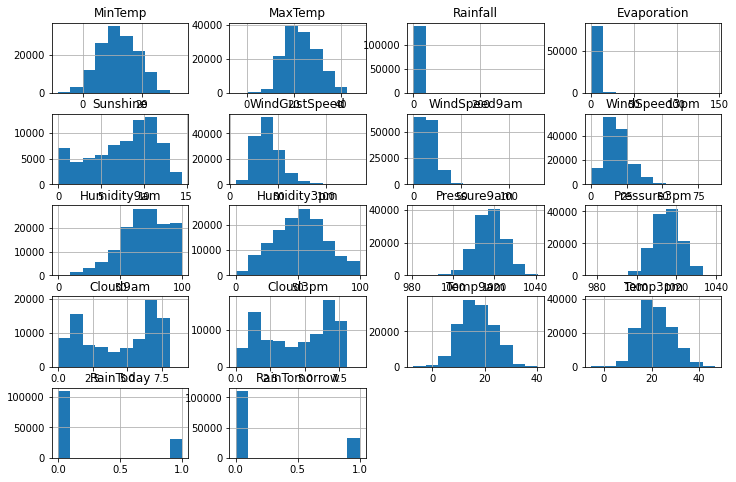

In [20]:
df[numerical_features].hist(figsize=(12, 8))
plt.show()
features_with_outliers = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

# Outliers: Rainfall, Evaporation and WindSpeed features

### Remove outliers

In [21]:
#features_with_outliers = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

In [22]:
for feature in features_with_outliers:
    q = df[feature].quantile(0.99)
    df = df[(df[feature]<q) | df[feature].isnull()]

# Display the frequency of each value in categorical variables

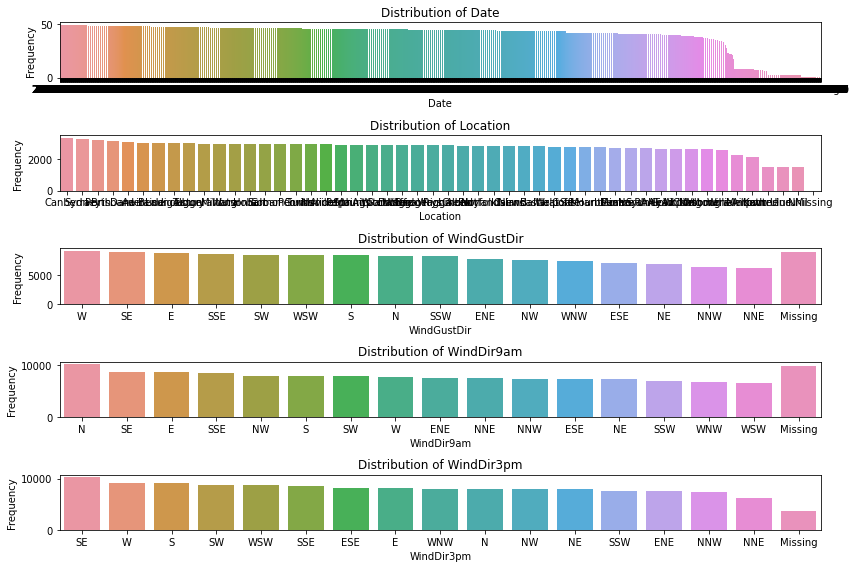

In [23]:
plt.figure(figsize=(12, 8))

for idx, feature in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, idx+1)  # Crear un subplot para cada variable categórica
    # Crear una copia temporal para la visualización
    temp_feature = df[feature].copy()
    # Reemplazar los nulos por "Missing" solo en la copia temporal
    temp_feature = temp_feature.fillna("Missing")
    
    # Obtener el orden de las categorías (excepto "Missing")
    category_order = [cat for cat in temp_feature.value_counts().index if cat != "Missing"]
    # Añadir "Missing" al final del orden
    category_order.append("Missing")
    
    # Crear el gráfico con el orden especificado
    sns.countplot(x=temp_feature, order=category_order)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [24]:
# Cramér's V calculation function
def cramers_v(x, y):
    # Create a contingency table
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, ex = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Main function to display the correlation between categorical features
def categorical_correlation(df, categorical_features, target):

    df['target_categorical'] = pd.cut(df[target], bins=5, labels=False, include_lowest=True)

    # Lista para almacenar los resultados de Cramér's V
    cramers_v_matrix = []

    # Iterar sobre las variables categóricas
    for feature in categorical_features:
        # Calcular la correlación entre la variable categórica y la variable target categorizada
        cramers_v_val = cramers_v(df[feature], df['target_categorical'])
        cramers_v_matrix.append([feature, 'target_categorical', cramers_v_val])
    
    # Convertir el resultado en un DataFrame
    cramers_v_df = pd.DataFrame(cramers_v_matrix, columns=['Feature', 'Target', 'Cramérs V'])
    
    # Eliminar la columna temporal 'target_categorical'
    df.drop(columns=['target_categorical'], inplace=True)

    return cramers_v_df

# Calcular la matriz de correlación
correlation_matrix = categorical_correlation(df, categorical_features, target)

# Mostrar el resultado
print(correlation_matrix)

       Feature              Target  Cramérs V
0         Date  target_categorical   0.345120
1     Location  target_categorical   0.152186
2  WindGustDir  target_categorical   0.107033
3   WindDir9am  target_categorical   0.131716
4   WindDir3pm  target_categorical   0.095269


#### Since data imputation is outside the scope of this project, no imputation will be performed for any feature. For features that exceed a certain threshold of missing values, these columns will simply be excluded from the analysis. For features with fewer missing values than the threshold, the corresponding records with missing values will be removed

In [25]:
def handle_missing_data(df, threshold=0.1):
    """
    Handles missing data by excluding features with missing values exceeding a certain threshold 
    and removing rows with missing values in features below the threshold.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - threshold (float): The threshold percentage of missing values. Features with missing values 
      exceeding this threshold will be excluded. Default is 0.2 (20%).

    Returns:
    - pd.DataFrame: The dataframe after handling missing data.
    """
    
    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean()
    
    # Find columns to drop (those that exceed the threshold)
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    # Find columns to keep
    columns_to_keep = missing_percentage[missing_percentage <= threshold].index
    
    # Store the number of columns to drop
    num_columns_dropped = len(columns_to_drop)
    
    # Exclude columns with missing values greater than the threshold
    df = df[columns_to_keep]
    
    # Count the number of rows with missing values in the remaining columns
    rows_with_missing_values = df.isnull().any(axis=1).sum()  # Count rows with at least one NaN
    
    # Drop rows with missing values
    df.dropna(inplace=True)
    
    # Output the information on dropped columns and rows
    print(f"Number of columns dropped: {num_columns_dropped}")
    print(columns_to_drop)
    print(f"Number of rows dropped: {rows_with_missing_values}")
    
    return df

# Example of how to use the function:
# Assuming df is your DataFrame
# df_cleaned = handle_missing_data(df, threshold=0.2)


df = handle_missing_data(df)

Number of columns dropped: 6
Index(['Evaporation', 'Sunshine', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm'],
      dtype='object')
Number of rows dropped: 19696


<ipython-input-25-57acb1895bde>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


# Prepare the dataset to build a pilot machine learning model

In [11]:
df.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000,115518.000000
mean,12.268545,23.425481,1.671632,39.361000,14.347954,18.508691,67.793643,50.575010,17.143044,21.920352,0.211742,0.208894
std,6.333831,7.093401,4.596034,11.731169,7.416961,7.719111,18.850246,20.647089,6.445188,6.958849,0.408545,0.406520
min,-8.500000,-4.800000,0.000000,7.000000,2.000000,2.000000,1.000000,0.000000,-7.200000,-5.400000,0.000000,0.000000
25%,7.700000,18.100000,0.000000,31.000000,9.000000,13.000000,56.000000,36.000000,12.400000,16.800000,0.000000,0.000000
50%,12.000000,23.000000,0.000000,39.000000,13.000000,19.000000,69.000000,51.000000,16.800000,21.400000,0.000000,0.000000
75%,16.900000,28.500000,0.600000,46.000000,19.000000,24.000000,81.000000,65.000000,21.700000,26.800000,0.000000,0.000000
max,33.900000,47.300000,37.200000,78.000000,35.000000,39.000000,100.000000,100.000000,40.200000,46.700000,1.000000,1.000000


In [12]:
def standardize_columns(df):
    """
    Automatically detects numerical columns and standardizes them using z-score normalization.
    
    :param df: pandas DataFrame
    :return: DataFrame with standardized numerical columns
    """
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if numeric_cols:
        print(f"Standardizing numerical columns: {numeric_cols}")
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        print("No numerical columns found to standardize.")
    
    return df


def label_encode_columns(df):
    """
    Automatically detects categorical columns and applies label encoding.
    
    :param df: pandas DataFrame
    :return: DataFrame with label-encoded categorical columns
    """
    df = df.copy()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_cols:
        print(f"Encoding categorical columns: {categorical_cols}")
        le = LabelEncoder()
        for col in categorical_cols:
            df[col] = le.fit_transform(df[col].astype(str))
    else:
        print("No categorical columns found to encode.")
    
    return df

#df = standardize_columns(df)
df = label_encode_columns(df)

Encoding categorical columns: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [13]:
df.drop('Date', axis=1, inplace=True)

In [14]:
X = df.drop(columns=[target])  
y = df[target]                

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Usa stratify si es clasificación
)

In [26]:
X.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm',
       'RainToday'],
      dtype='object')

In [17]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8597212603878116

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     18278
           1       0.76      0.48      0.59      4826

    accuracy                           0.86     23104
   macro avg       0.82      0.72      0.75     23104
weighted avg       0.85      0.86      0.85     23104



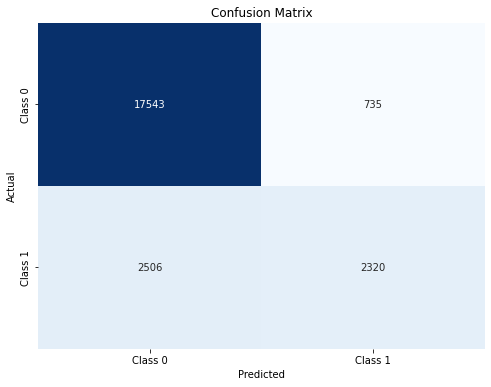

In [18]:
cm = confusion_matrix(y_test, y_pred)

# Configura el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crea el heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], cbar=False)

# Añadir títulos y etiquetas
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Muestra el gráfico
plt.show()